In [ ]:
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/FYP"

/content/drive/MyDrive/FYP


In [ ]:
!unzip "KolektorSDD2 - T4791 - B2085 - D2706.zip" -d "/content"
clear_output()

# SEMANTIC SEGMENTATION ON KOLEKTORSDD2 SURFACE DEFECTS

<table style="position:relative; right:50px;">
    <tr><td colspan="3" rowspan="12"><img src="https://www.vicos.si/resources/kolektorsdd2/images/kolektor-sdd2-types.png" width=350></td></tr>
    <tr><td><b>Benchmark Reference</b></td> 
        <td colspan="2"><a href="https://prints.vicos.si/publications/385">Mixed supervision for surface-defect detection: <br> from weakly to fully supervised learning</a></td></tr>
    <tr><td><b>Number of Classes</b></td> 
        <td>2</td>
        <td><b>Negative</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Positive</b></td></tr>
    <tr><td><b>Number of Samples</b></td>
        <td>3335</td>
        <td><b>356 (Defect)</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>2979 (Defect-Free)</b></td></tr>
    <tr><td><b>Image Property</b></td>
        <td>Color</td>
        <td></td></tr>
    <tr><td><b>Image Size</b></td>
        <td>≅ 230 x 630</td>
        <td></td></tr>
</table>

## CHAPTER 0: IMPORT NECESSARY PYTHON LIBRARIES

In [ ]:
import os
import cv2
import time
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## CHAPTER 1: DATA PREPARATION

In [ ]:
# set some global parameters
BATCH_SIZE = 5    # Number of training examples utilized in one iteration
IMG_WIDTH = 96    
IMG_HEIGHT = 96
IMG_CHANNELS = 3

TRAIN_IMG_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/train/*'
TRAIN_MASK_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/train/*'
TEST_IMG_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/test/*'
TEST_MASK_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/test/*'

In [ ]:
# get Image and Mask IDs
import glob

TrainImgPaths = []
TrainMaskPaths = []
TestImgPaths = []
TestMaskPaths = []

for name in glob.glob(TRAIN_IMG_PATH):
  if name.endswith("_GT.png"):
    TrainMaskPaths.append(name)
  else:
    TrainImgPaths.append(name)

for name in glob.glob(TEST_IMG_PATH):
  if name.endswith("_GT.png"):
    TestMaskPaths.append(name)
  else:
    TestImgPaths.append(name)

print(len(TrainMaskPaths), len(TrainImgPaths), len(TestMaskPaths), len(TestImgPaths))

4791 4793 1004 1004


In [ ]:
# remove images that dont have corresponding ground truth masks
for name in TrainImgPaths:
  index = name.find('.png')
  if not (name[:index] + '_GT' + name[index:]) in TrainMaskPaths:
    TrainImgPaths.remove(name)

print(len(TrainImgPaths))

4791


In [ ]:
TrainImgPaths.sort()
TrainMaskPaths.sort()
TestImgPaths.sort()
TestMaskPaths.sort()

In [ ]:
# declare lists to record image and mask paths that contains defect
train_defect_imagePath = []
train_defect_maskPath = []
test_defect_imagePath = []
test_defect_maskPath = []

In [ ]:
# find out image and mask paths that contains defect
zero_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=int)
for maskPath in TrainMaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    if not np.array_equal(mask, zero_mask):
      train_defect_maskPath.append(maskPath)
      train_defect_imagePath.append(maskPath.replace("_GT", ""))

for maskPath in TestMaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    if not np.array_equal(mask, zero_mask):
      test_defect_maskPath.append(maskPath)
      test_defect_imagePath.append(maskPath.replace("_GT", ""))

print(len(train_defect_imagePath), len(train_defect_maskPath), len(test_defect_imagePath), len(test_defect_maskPath))

2706 2706 110 110


In [ ]:
train_class_label = []
test_class_label = []
for imagePath in TrainImgPaths:
  if imagePath in train_defect_imagePath:
    train_class_label.append("Defective")
  else:
    train_class_label.append("Background")

for imagePath in TestImgPaths:
  if imagePath in test_defect_imagePath:
    test_class_label.append("Defective")
  else:
    test_class_label.append("Background")

print(np.column_stack(np.unique(train_class_label, return_counts=True)))
print(np.column_stack(np.unique(test_class_label, return_counts=True)))

[['Background' '2085']
 ['Defective' '2706']]
[['Background' '894']
 ['Defective' '110']]


In [ ]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_class_label = lb.fit_transform(train_class_label)
test_class_label = lb.fit_transform(test_class_label)
train_class_label = np.array(train_class_label)
test_class_label = np.array(test_class_label)

In [ ]:
# declare four lists to store all the input images and masks
train_images = []
train_masks = []
test_images = []
test_masks = []

In [ ]:
# loop over the image paths
for imagePath in TrainImgPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    # set cv2.INTER_AREA as the image resize interpolation method as it typically yields more aesthetically pleasing results
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    train_images.append(image)

for imagePath in TestImgPaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    test_images.append(image)

In [ ]:
# loop over the image paths
for maskPath in TrainMaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    train_masks.append(mask)

for maskPath in TestMaskPaths:
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    test_masks.append(mask)

## CHAPTER 2: DATA PRE-PROCESSING

In [ ]:
# convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range [0, 1]
train_images = np.array(train_images, dtype="float64") / 255.
train_masks = np.array(train_masks, dtype="float64") / 255.
test_images = np.array(test_images, dtype="float64") / 255.
test_masks = np.array(test_masks, dtype="float64") / 255.
print(train_images.shape, train_masks.shape, test_images.shape, test_masks.shape)

(4791, 96, 96, 3) (4791, 96, 96) (1004, 96, 96, 3) (1004, 96, 96)


In [ ]:
# change pixel level masks to boolean type (True / False)
train_compared_mask = np.zeros((train_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
test_compared_mask = np.zeros((test_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

train_masks = train_masks.reshape((train_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
train_masks = np.maximum(train_masks, train_compared_mask)
train_masks = (train_masks > 0).astype(bool)

test_masks = test_masks.reshape((test_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
test_masks = np.maximum(test_masks, test_compared_mask)
test_masks = (test_masks > 0).astype(bool)

In [ ]:
# CLASS IMBALANCE
def add_sample_weights(label=train_masks):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tensorflow.constant([1.0, 1.0])
  class_weights = class_weights/tensorflow.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights`
  sample_weights = tensorflow.gather(class_weights, indices=tensorflow.cast(label, tensorflow.int32))

  return sample_weights.numpy()

In [ ]:
# transforming images and labelled masks together
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
seed = 1
# data_gen_args = dict(rotation_range=90,      # rotation
#                      width_shift_range=0.2,  # horizontal shift
#                      height_shift_range=0.2, # vertical shift
#                      zoom_range=[0.5,1.0]    # zoom
#                     )

# train_datagen = ImageDataGenerator(**data_gen_args)
train_datagen = ImageDataGenerator()

# train_datagen.fit(train_images, augment=True, seed=seed)
train_datagen.fit(train_images, augment=False, seed=seed)

train_generator = train_datagen.flow(x=train_images,
                                     y=train_class_label,
                                     sample_weight=add_sample_weights(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     seed=seed)

In [ ]:
# creating the testing Image and Mask generator
test_datagen = ImageDataGenerator()

test_datagen.fit(test_images, augment=False, seed=seed)

test_generator = test_datagen.flow(x=test_images,
                                   y=test_class_label,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   seed=seed)

## CHAPTER 3: MODEL ARCHITECTURE CONSTRUCTION

In [ ]:
!pip install einops
!pip install tensorflow-addons
!pip install --quiet vit-keras
!pip install -q git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import math
import tensorflow_addons as tfa
from einops import rearrange
from tensorflow.image import extract_patches
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Embedding, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dropout, Permute, ReLU, Softmax
from tensorflow.keras.layers import Concatenate, Reshape, Add
from tensorflow.keras.activations import gelu, relu, softmax
# from tensorflow.keras.layers import UpSampling2D
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Reshape
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dropout, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, BinaryIoU

In [ ]:
# initialize our initial learning rate, number of epochs to train for
INIT_LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 20

In [ ]:
def class_predicted(class_score):
  class_score = np.argmax(class_score, axis=-1)
  return class_score

In [ ]:
# visualize and compare predicted mask output with ground truth mask
from tensorflow.keras.utils import array_to_img
def show_predictions(dataset=train_generator):
    plt.figure(figsize=(7, 7))
    image, label, weight = next(iter(dataset))
    image = image[0][np.newaxis, :]
    label = label[0]

    outputs = model.predict(image)
    class_score = outputs[0][0]
    conv_fm = outputs[1][0]
    inds_sort = class_predicted(class_score)

    H, W, C = conv_fm.shape
    fc_weights = np.array(model.get_layer('final_dense').get_weights())[0][:, inds_sort]
    fc_weights = np.reshape(fc_weights, [-1, 1, C])
    conv_fm = np.reshape(conv_fm, [-1, H * W, C])
    detection_map = tensorflow.matmul(conv_fm, fc_weights, adjoint_b=True)
    detection_map = tensorflow.reshape(detection_map, [-1, H, W]).numpy()

    print("True class label: " + lb.inverse_transform([label])[0])
    print("Predicted class label: " + lb.inverse_transform([class_predicted(class_score)])[0])

    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(np.squeeze(image, axis=0)))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(np.squeeze(np.expand_dims(detection_map, axis=-1), axis=0)))
    plt.axis('off')
    plt.show()

#### MODEL: CAM
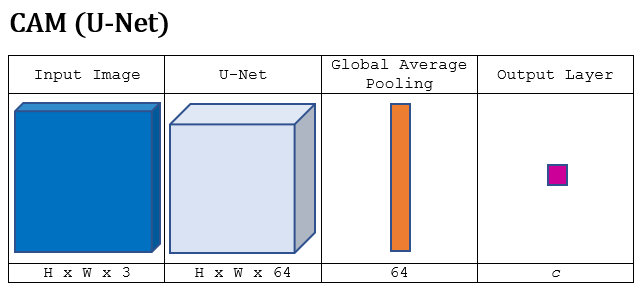

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.output

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# bottom block and start upsampling
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(intermediate)
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 1
maskHead = Concatenate()([vgg.get_layer('block5_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 2
maskHead = Concatenate()([vgg.get_layer('block4_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(256, 3)(maskHead)

# concatenation block 3
maskHead = Concatenate()([vgg.get_layer('block3_conv3').output, maskHead])
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(128, 3)(maskHead)

# concatenation block 4
maskHead = Concatenate()([vgg.get_layer('block2_conv2').output, maskHead])
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(64, 3)(maskHead)

# concatenation block 5
maskHead = Concatenate()([vgg.get_layer('block1_conv2').output, maskHead])
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)
finalConv = Conv2D(64, (3,3), activation='relu', padding='same', name='final_conv')(maskHead)

# global average pooling
avgPool = GlobalAveragePooling2D(data_format='channels_last')(finalConv)

# final classification layer
classHead = Dense(len(lb.classes_), activation='softmax', use_bias=False, name='final_dense')(avgPool)

# put together our model which accept an input image and then output a class label
model = Model(
    inputs=vgg.input,
    outputs=[classHead, finalConv])

In [ ]:
# initialize the loss, optimizer, metrics, compile the model, and show the model summary
losses = {
    "final_dense": "sparse_categorical_crossentropy",
    "final_conv" : None
}

metrics = {
    "final_dense": "accuracy",
    "final_conv" : None
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "final_dense": 10.0,
    "final_conv": None
}

# initialize the optimizer, compile the model, and show the model summary
# opt = Adam(INIT_LR)
model.compile(loss=losses, optimizer=tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY), metrics=metrics, loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

True class label: Defective
Predicted class label: Defective


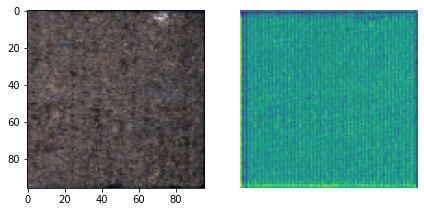

In [ ]:
show_predictions()

## CHAPTER 4: MODEL TRAINING

In [ ]:
# visualize the changes in predicted mask output for every epoch
from IPython.display import clear_output
class DisplayCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
import tensorflow.keras.callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    mode='min',
    save_weights_only=False,
    save_best_only=True
    )

True class label: Defective
Predicted class label: Defective


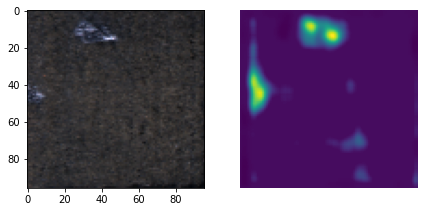


Sample Prediction after epoch 20

958/958 [==============================] - 80s 84ms/step - loss: 0.2136 - final_dense_loss: 0.0214 - final_dense_accuracy: 0.9858 - val_loss: 0.8957 - val_final_dense_loss: 0.0896 - val_final_dense_accuracy: 0.9800


In [ ]:
# model training
VAL_SUBSPLITS = 5
print("[INFO] training model...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_images)//BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=len(test_images)//BATCH_SIZE//VAL_SUBSPLITS,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[DisplayCallback(), model_checkpoint_callback])

## CHAPTER 5: MODEL TESTING

#### CONFUSION MATRIX (CM)

In [ ]:
# Confusion Matrix (CM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

def plot_confusion_matrix(m, title='Confusion matrix'):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    
    cmap = ListedColormap([[1, 1, 1]])
    img = ax.matshow(m, cmap=cmap)
    plt.title(title)
    
    for (i, j), z in np.ndenumerate(m):
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, lb.classes_)
    plt.yticks(tick_marks, lb.classes_)
    plt.ylabel('GROUND TRUTH')
    plt.xlabel('PREDICTED')

#### TP/FP/TN/FN & PIXEL ACCURACY (PA) & DICE & INTERSECTION OVER UNION (IoU)

In [ ]:
# TP/FP/TN/FN & Pixel Accuracy (PA) & Intersection Over Union (IoU) & Dice Score
def TP_TN_FP_FN_PA_IOU_DICE(confusion_m, model_name, l=len(lb.classes_)):
    TP = np.zeros((len(model_name), l))
    TN = np.zeros((len(model_name), l))
    FP = np.zeros((len(model_name), l))
    FN = np.zeros((len(model_name), l))
    
    for index, cm in enumerate(confusion_m):
        TP[index] = np.diag(cm)
        
        for i in range(l):
            temp = np.delete(cm, i, 0)   # delete ith row
            temp = np.delete(temp, i, 1)  # delete ith column
            TN[index][i] = sum(sum(temp))

        for i in range(l):
            FP[index][i] = sum(cm[:,i]) - cm[i,i]

        for i in range(l):
            FN[index][i] = sum(cm[i,:]) - cm[i,i]

    print('                         | ' + model_name[0])
    print("*************************|" + '**********************')
    for i in range(l):
        print("True Positive \t\t |", "{:.2f}".format(TP[0][i]))
        print("True Negative \t\t |", "{:.2f}".format(TN[0][i]))
        print("False Positive \t\t |", "{:.2f}".format(FP[0][i]))
        print("False Negative \t\t |", "{:.2f}".format(FN[0][i]))
        print("Precision Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FP[0][i])*100))
        print("Recall Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FN[0][i])*100))
        print("Pixel Accuracy \t\t |", 
             "{:.2f}".format((TP[0][i] + TN[0][i]) / (TP[0][i] + TN[0][i] + FP[0][i] + FN[0][i])*100))
        print("Intersection Over Union  |", 
             "{:.2f}".format((TP[0][i]) / (TP[0][i] + FP[0][i] + FN[0][i])*100))
        print("Dice Score \t\t |", 
             "{:.2f}".format((2*TP[0][i]) / (2*TP[0][i] + FP[0][i] + FN[0][i])*100))
        print('-----------------------------------------------')
    print('***********************************************')

#### MEAN INTERSECTION OVER UNION (IoU)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
def mean_IOU(y_true, y_pred, smooth=0.001):
    m = MeanIoU(num_classes=len(lb.classes_))
    m.update_state(y_true, y_pred)
    mean_iou = m.result().numpy()
    
    return mean_iou

#### ... START EVALUATION ON TEST SET ...

In [ ]:
CAM = load_model('WEAKLY_SUPERVISED_SEMANTIC_SEGMENTATION_KOLEKTORSDD2_CAM.h5',
                  custom_objects={'AdamW': tfa.optimizers.AdamW})

In [ ]:
# declare two lists to record image and mask paths that contains defect
test_defect_imagePath = []
test_defect_maskPath = []

In [ ]:
# find out image and mask paths that contains defect
zero_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=int)
for maskPath in TestMaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    if not np.array_equal(mask, zero_mask):
      test_defect_maskPath.append(maskPath)
      test_defect_imagePath.append(maskPath.replace("_GT", ""))

print(len(test_defect_imagePath), len(test_defect_maskPath))

110 110


In [ ]:
test_imgs_validation = []
test_masks_validation= []

for maskPath in test_defect_maskPath:
  img_path = maskPath.replace("_GT", "")
  mask_path = maskPath

  image = cv2.imread(img_path)
  image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
  test_imgs_validation.append(image)

  mask = cv2.imread(mask_path, 0)
  mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
  test_masks_validation.append(mask)

test_imgs_validation = np.array(test_imgs_validation, dtype="float64") / 255.
test_masks_validation = np.array(test_masks_validation, dtype="float64") / 255.

test_compared_mask = np.zeros((test_masks_validation.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
test_masks_validation = test_masks_validation.reshape((test_masks_validation.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
test_masks_validation = np.maximum(test_masks_validation, test_compared_mask)
test_masks_validation = (test_masks_validation > 0).astype(bool)
print(test_imgs_validation.shape, test_masks_validation.shape)

(110, 96, 96, 3) (110, 96, 96, 1)


In [ ]:
from tensorflow.keras.utils import array_to_img
detection_maps = []
image = test_imgs_validation
label = test_masks_validation

for image, label in zip(test_imgs_validation, test_masks_validation):
  outputs = CAM.predict(image[np.newaxis, :])
  class_score = outputs[0][0]
  conv_fm = outputs[1][0]
  inds_sort = class_predicted(class_score)

  H, W, C = conv_fm.shape
  fc_weights = np.array(CAM.get_layer('final_dense').get_weights())[0][:, inds_sort]
  fc_weights = np.reshape(fc_weights, [-1, 1, C])
  conv_fm = np.reshape(conv_fm, [-1, H * W, C])
  detection_map = tensorflow.matmul(conv_fm, fc_weights, adjoint_b=True)
  detection_map = tensorflow.reshape(detection_map, [-1, H, W]).numpy()
  detection_map = np.squeeze(np.expand_dims(detection_map, axis=-1), axis=0)
  detection_map = (detection_map - np.min(detection_map)) / (np.max(detection_map) - np.min(detection_map))
  detection_map = (detection_map > 0.5).astype(bool)
  detection_maps.append(detection_map)

detection_maps = np.array(detection_maps)
detection_maps_flatten = detection_maps.flatten().astype('int')
print(detection_maps.shape, detection_maps_flatten.shape)

(110, 96, 96, 1) (1013760,)


In [ ]:
train_cm = confusion_matrix(test_masks_validation.flatten().astype('int'), detection_maps_flatten)

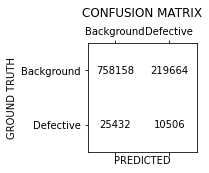

In [ ]:
plot_confusion_matrix(train_cm, title='CONFUSION MATRIX\n')

In [ ]:
# PA_IOU
TP_TN_FP_FN_PA_IOU_DICE([train_cm], ["CAM"])

                         | CAM
*************************|**********************
True Positive 		 | 758158.00
True Negative 		 | 10506.00
False Positive 		 | 25432.00
False Negative 		 | 219664.00
Precision Rate 		 | 96.75
Recall Rate 		 | 77.54
Pixel Accuracy 		 | 75.82
Intersection Over Union  | 75.57
Dice Score 		 | 86.09
-----------------------------------------------
True Positive 		 | 10506.00
True Negative 		 | 758158.00
False Positive 		 | 219664.00
False Negative 		 | 25432.00
Precision Rate 		 | 4.56
Recall Rate 		 | 29.23
Pixel Accuracy 		 | 75.82
Intersection Over Union  | 4.11
Dice Score 		 | 7.90
-----------------------------------------------
***********************************************


In [ ]:
mean_IoU_score = mean_IOU(test_masks_validation.flatten().astype('int'), detection_maps_flatten)
print("Intersection over Union :| " + "{:.2f}".format(mean_IoU_score*100))

Intersection over Union :| 39.84


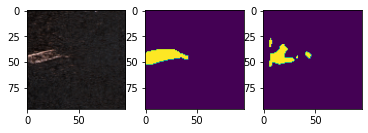

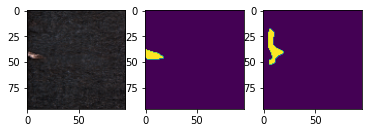

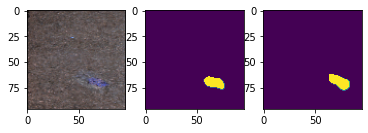

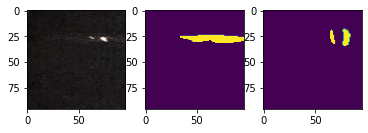

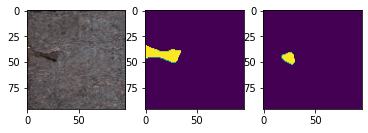

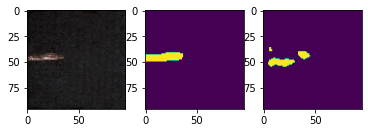

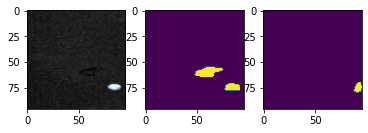

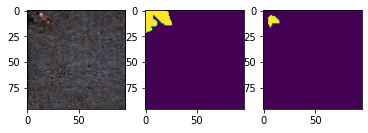

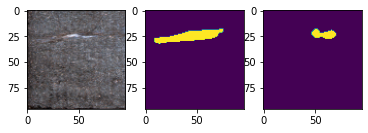

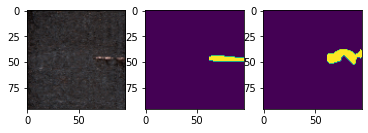

In [ ]:
for i in range(10):  
  plt.subplot(1, 3, 1)
  plt.imshow(array_to_img(test_imgs_validation[i]))
  plt.subplot(1, 3, 2)
  plt.imshow(array_to_img(test_masks_validation[i]))
  plt.subplot(1, 3, 3)
  plt.imshow(array_to_img(detection_maps[i]))
  plt.show()